In [1]:
import itertools
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

%matplotlib inline

In [16]:
def get_data(filename):
    ids = []
    data = []
    labels = []
    with open(filename, 'rb') as f:
        while 1:
            try:
                d = pkl.load(f)
                features = []
                for lb in ['PA', 'PB', 'AP', 'BP', 'AB', 'BA']:
                    if len(d[lb]) == 0:
                        break
                    att_tensor = np.array(d[lb])
                    max_att = np.max(att_tensor, axis=0)
                    features.append(max_att[:, :].flatten())

                    mean_att = np.mean(att_tensor, axis=0)
                    features.append(mean_att[16:20, :].flatten())

                    min_att = np.min(att_tensor, axis=0)
                    features.append(min_att[16:20, :].flatten())
#                 for lb in ['AP', 'BP']:
#                     if len(d[lb]) == 0:
#                         break
#                     att_tensor = np.array(d[lb])
#                     max_att = np.max(att_tensor, axis=0)
#                     features.append(max_att[14:22, :].flatten())

                    # mean_att = np.mean(att_tensor, axis=0)
                    # features.append(mean_att[16:20, :].flatten())

                    # min_att = np.min(att_tensor, axis=0)
                    # features.append(min_att[16:20, :].flatten())

                if len(d[lb]) == 0:
                    print(d['ID'])
                    continue
                labels.append(d['label'])
                ids.append(d['ID'])
                data.append(np.concatenate(features))
            except EOFError:
                break
    return ids, data, labels

def convert_label(Y_train):
    Y_train_ones = []
    for y in Y_train:
        if y == 'A':
            Y_train_ones.append(0)
        elif y == 'B':
            Y_train_ones.append(1)
        else:
            Y_train_ones.append(2)
    return Y_train_ones

In [17]:
OOF_NAME, DATA = 'lgbm_large_mgap', 'large-atts-mgap'
IDs_train1, X_train1, Y_train1 = get_data('./data/%s-validation.pkl' %DATA)
IDs_train2, X_train2, Y_train2 = get_data('./data/%s-test.pkl'%DATA)
IDs_test, X_test, Y_test = get_data('./data/%s-development.pkl'%DATA)
IDs_train = IDs_train1 + IDs_train2
X_train = X_train1 + X_train2
Y_train = Y_train1 + Y_train2

In [4]:
NTRAIN, NTEST = len(X_train), len(X_test)
Y_train_ones = convert_label(Y_train)
Y_test_ones = convert_label(Y_test)

X, y = np.array(X_train), np.array(Y_train_ones)
X_test, y_test = np.array(X_test), np.array(Y_test_ones)

In [5]:
column_indices = []
for fttt in ['PA', 'PB', 'AP', 'BP', 'AB', 'BA']:
    for l in range(0, 24):
        for h in range(0, 16):
            column_indices.append(f'{fttt}L{l}H{h}')
# for fttt in ['AP', 'BP']:
#     for l in range(14, 22):
#         for h in range(0, 16):
#             column_indices.append(f'{fttt}L{l}H{h}')
len(column_indices)

2304

In [15]:
N_CLASSES = 3
EARLY_STOPPING=250
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'max_depth': 4,
    'num_leaves': 31,
    'feature_fraction': 0.2,
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.02,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'verbose': -1,
    'nthread': 12
}  

KFOLD, SHUF, RS = 5, True, 123
OOF_TRAIN = np.zeros((NTRAIN, N_CLASSES))
OOF_TEST = np.zeros((NTEST, N_CLASSES))
val_score_list = []
kf = StratifiedKFold(n_splits=KFOLD, shuffle=SHUF, random_state=RS)
# dtest = xgb.DMatrix(data=X_test)
for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("FOLD #", i)
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[val_idx], y[val_idx]
    
    lgtrain = lgb.Dataset(X_train, y_train)
    lgvalid = lgb.Dataset(X_valid, y_valid)

    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1000,
        valid_sets=[lgvalid],
        valid_names=['valid'],
        early_stopping_rounds=EARLY_STOPPING,
        verbose_eval=50,
        feature_name=column_indices
    )
#     ax = lgb.plot_importance(lgb_clf, max_num_features=30, figsize=(10,17))
#     plt.show()
#     val_preds = lgb_clf.predict(X_valid)
#     err = log_loss(y_valid, val_preds)
#     test_preds = lgb_clf.predict(X_test, raw_score=True)
#     test_preds = softmax(test_preds, axis=1)
#     OOF_TEST += test_preds
#     val_preds = lgb_clf.predict(X_valid, raw_score=True)
#     val_preds = softmax(val_preds, axis=1)
#     OOF_TRAIN[val_idx] = val_preds
    break


FOLD # 0
Training until validation scores don't improve for 250 rounds.
[50]	valid's multi_logloss: 0.558887
[100]	valid's multi_logloss: 0.383345
[150]	valid's multi_logloss: 0.318159
[200]	valid's multi_logloss: 0.291692
[250]	valid's multi_logloss: 0.279277
[300]	valid's multi_logloss: 0.273835
[350]	valid's multi_logloss: 0.269483
[400]	valid's multi_logloss: 0.267725
[450]	valid's multi_logloss: 0.267135
[500]	valid's multi_logloss: 0.267871
[550]	valid's multi_logloss: 0.269359
[600]	valid's multi_logloss: 0.271581
[650]	valid's multi_logloss: 0.273196
Early stopping, best iteration is:
[429]	valid's multi_logloss: 0.266589


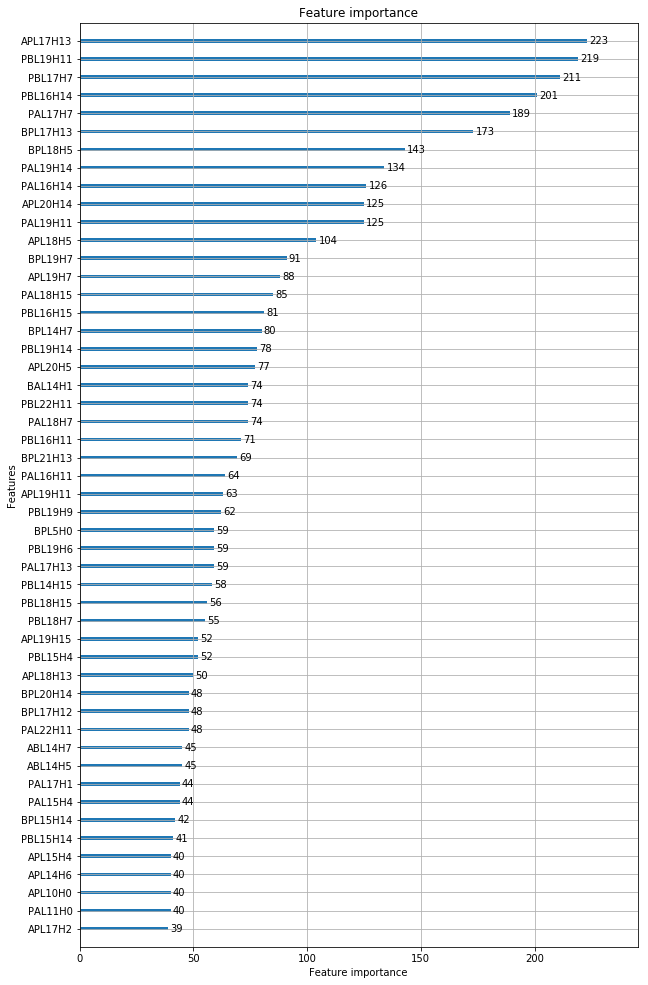

In [7]:
ax = lgb.plot_importance(lgb_clf, max_num_features=50, figsize=(10,17))
plt.show()

In [96]:
# submission = pd.read_csv('input/sample_submission_stage_1.csv', index_col='ID')
# for _id, pred in zip(IDs_test, Y_pred):
#     submission.loc[_id, 'A'] = pred[0]
#     submission.loc[_id, 'B'] = pred[1]
#     submission.loc[_id, 'NEITHER'] = pred[2]
# submission.to_csv(f'output/TPOT.csv')